In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekyaarra","key":"383778af7e1547e15e553a22d7d9a00d"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!pwd

/content


In [7]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

100% 985M/987M [00:11<00:00, 199MB/s]
100% 987M/987M [00:11<00:00, 92.9MB/s]


In [ ]:
!unzip /content/speech-emotion-recognition-en.zip

In [9]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [10]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
  #TESS
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"

  #SAVDESS
        elif('n' in name): return "02"
        elif('h' in name): return "03"
        elif('sa' in name): return "04"
        elif('f' in name): return "06"
        elif('a' in name): return "05"
        elif('d' in name): return "07"
        elif('su' in name): return "08"

        else: return "-1"


# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [ ]:
# Maximum samples count for padding purposes.
from tqdm import tqdm
sample_lengths = []
folder_path = '/content/drive/MyDrive/Datathon/Ravdess/audio_speech_actors_01-24'

for subdir, dirs, files in tqdm(os.walk(folder_path)):
  for file in files:
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    normalizedsound = effects.normalize(rawsound, headroom = 0)
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    sample_lengths.append(len(xt))

# f_path = '/content/drive/MyDrive/Datathon/Tess'
# for subdir, dirs, files in tqdm(os.walk(f_path)):
#   for file in files:
#     x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
#     xt, index = librosa.effects.trim(x, top_db=30)
#     sample_lengths.append(len(xt))

print('\nMaximum sample length:', np.max(sample_lengths))

3it [01:07, 22.42s/it]


KeyboardInterrupt: 

In [ ]:
f_path = '/content/drive/MyDrive/Datathon/Tess'
for subdir, dirs, files in tqdm(os.walk(f_path)):
  for file in files:
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    normalizedsound = effects.normalize(rawsound, headroom = 0)
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    sample_lengths.append(len(xt))

print('\nMaximum sample length:', np.max(sample_lengths))

In [ ]:
p1 = '/content/drive/MyDrive/Datathon/Crema'
for subdir, dirs, files in tqdm(os.walk(p1)):
  for file in files:
    #print(os.path.join(subdir,file))
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    normalizedsound = effects.normalize(rawsound, headroom = 0)
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    sample_lengths.append(len(xt))

print('\nMaximum sample length:', np.max(sample_lengths))

In [ ]:
p2 = '/content/drive/MyDrive/Datathon/Savee'
for subdir, dirs, files in tqdm(os.walk(p2)):
  for file in files:
    #print(os.path.join(subdir,file))
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    normalizedsound = effects.normalize(rawsound, headroom = 0)
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    sample_lengths.append(len(xt))

print('\nMaximum sample length:', np.max(sample_lengths))

In [ ]:
def fea(folder_path):
  for subdir, dirs, files in tqdm(os.walk(folder_path)):
    for file in files:

      # Fetch the sample rate.
        _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
      # Load the audio file.
        rawsound = AudioSegment.from_file(os.path.join(subdir,file))
      # Normalize the audio to +5.0 dBFS.
        normalizedsound = effects.normalize(rawsound, headroom = 0)
      # Transform the normalized audio to np.array of samples.
        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
        #print("normal " + str(len(normal_x)))
      # Trim silence from the beginning and the end.
        xt, index = librosa.effects.trim(normal_x, top_db=30)
        #print("xt " + str(len(xt)))
        #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed--
      # Pad for duration equalization.
        padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
      # Noise reduction.
        final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22

    # Features extraction
        f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
        f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR
        f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

    # Emotion extraction from the different databases
        if (find_emotion_T(file) != "-1"): #TESS database validation
              name = find_emotion_T(file)
        else:                              #RAVDESS database validation
              name = file[6:8]

    # Filling the data lists
        rms.append(f1)
        zcr.append(f2)
        mfcc.append(f3)
        emotions.append(emotionfix(name))

# toc = time.perf_counter()
# print(f"Running time: {(toc - tic)/60:0.4f} minutes")

In [ ]:
# import time
# tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 314818 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/MyDrive/Datathon/Ravdess/audio_speech_actors_01-24'
f_path = '/content/drive/MyDrive/Datathon/Tess'

print("---Ravdess---\n")
fea(folder_path)
print("---Tess---\n")
fea(f_path)


In [ ]:
print("---Savee---\n")
fea(p2)

In [ ]:
# f_rms = np.array(rms, dtype=object)

In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist()
x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew_10.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist()
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew_10.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

#from here

In [13]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = '/content/drive/MyDrive/Colab Notebooks/X_datanew_10.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = '/content/drive/MyDrive/Colab Notebooks/Y_datanew_10.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [14]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [15]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(4130, 615, 15)
(410, 615, 15)
(180, 615, 15)


In [16]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[4], [4], [4], [5], [7], [3], [6], [3], [5], [4], [0], [7], [3], [4], [7], [3], [5], [2], [6], [4], [4], [5], [4], [5], [4], [5], [0], [4], [3], [7], [4], [7], [0], [4], [4], [5], [6], [4], [3], [4], [4], [4], [4], [0], [4], [1], [4], [3], [4], [0], [0], [2], [5], [4], [5], [2], [4], [7], [4], [4], [5], [4], [3], [4], [4], [4], [4], [0], [0], [2], [4], [5], [4], [2], [6], [7], [4], [4], [4], [5], [2], [3], [4], [4], [4], [5], [3], [4], [4], [3], [3], [5], [4], [5], [4], [4], [2], [4], [4], [6], [2], [2], [3], [2], [5], [5], [4], [0], [2], [3], [4], [3], [5], [7], [4], [0], [5], [4], [4], [2], [4], [4], [4], [4], [2], [4], [1], [4], [4], [0], [0], [0], [5], [4], [4], [7], [2], [4], [5], [4], [4], [5], [0], [7], [4], [2], [4], [4], [0], [4], [4], [4], [3], [4], [4], [6], [3], [6], [4], [5], [6], [1], [4], [6], [4], [6], [6], [4], [4], [3], [4], [4], [4], [4], [4], [4], [2], [4], [4], [1]], "dtype": "int8", "shape": [180, 1], "Corder": true}'

In [17]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks

In [19]:
model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/MyDrive/Datathon/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.1, patience=100)

# Compile & train
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                      epochs=300, batch_size = batch_size,
                      validation_data = (x_val, y_val_class),
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 615, 64)           20480     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 54024 (211.03 KB)
Trainable params: 54024 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/300
180/180 [==============================] - 12s 43ms/step - loss: 1.7674 - categorical_accuracy: 0.4242 - val_loss: 1.7334 - val_categorical_accuracy: 0.4488 - lr: 0.0010
Epoch 2/300
180/180 [==============================] - 8s 46ms/step - loss: 1.6394 - categori

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

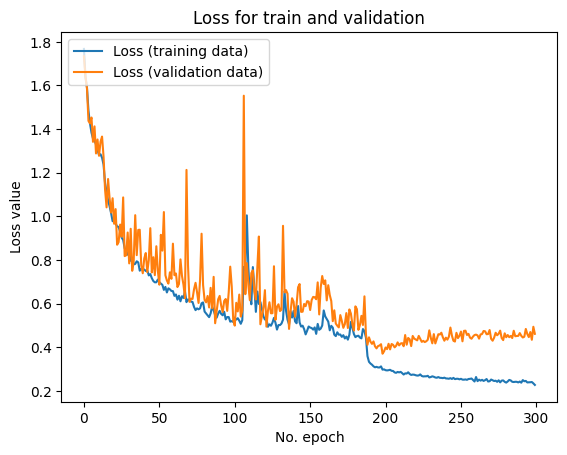

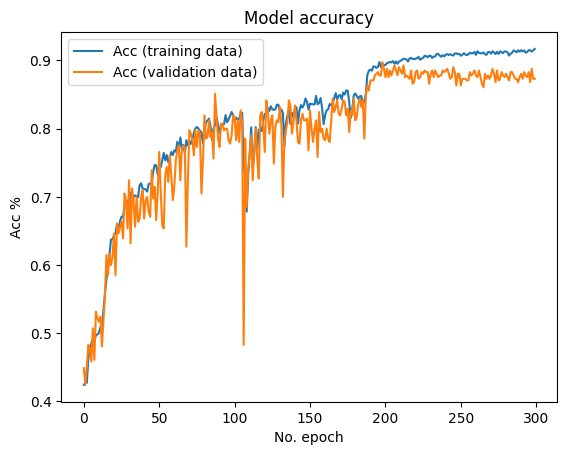

In [21]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [22]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

13/13 - 0s - loss: 0.3710 - categorical_accuracy: 0.8976 - 213ms/epoch - 16ms/step


In [23]:
# Validation Confusion matrix

y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

13/13 [==============================] - 1s 14ms/step


NameError: name 'pd' is not defined

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

In [24]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/MyDrive/SER/model.json'
saved_weights_path = '/content/drive/MyDrive/SER/model_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


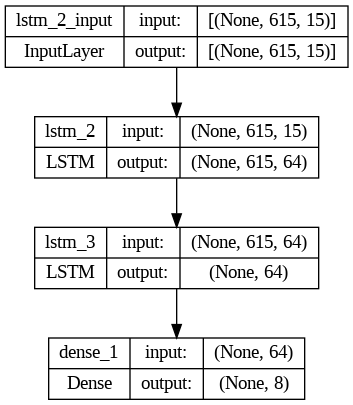

In [25]:
# Reading the model from JSON file

saved_model_path = '/content/drive/MyDrive/SER/model.json'
saved_weights_path = '/content/drive/MyDrive/SER/model_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

4/4 - 0s - loss: 0.1264 - categorical_accuracy: 0.9346 - 234ms/epoch - 59ms/step


4/4 [==============================] - 0s 21ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

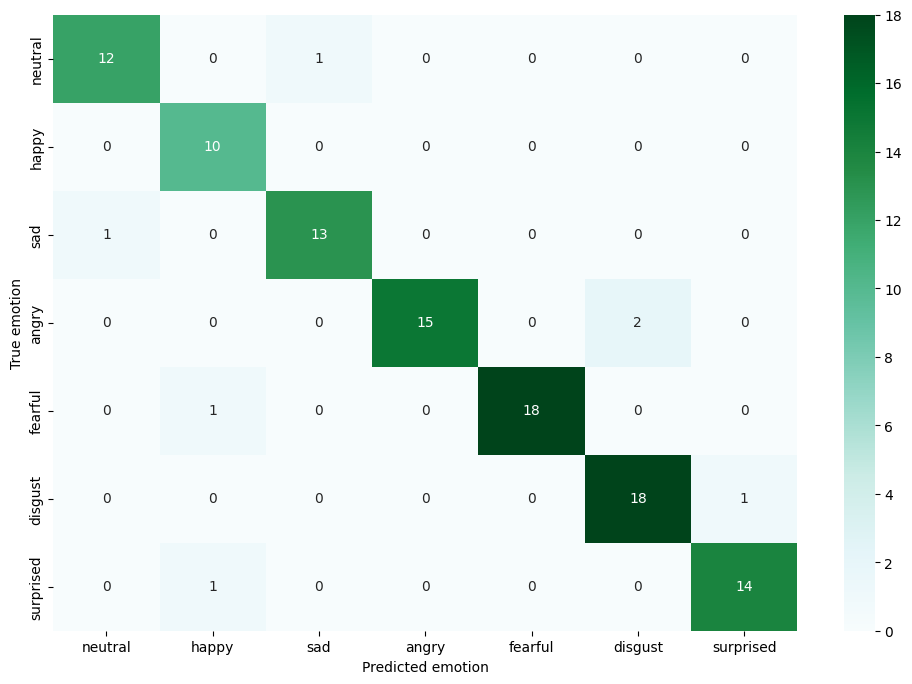

In [ ]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.9730
happy : 0.8718
sad : 1.0000
angry : 0.9714
fearful : 0.9722
disgust : 1.0000
surprised : 0.9286
